In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, classification_report, silhouette_score

In [3]:
df = pd.read_csv("cleaned_data.csv")

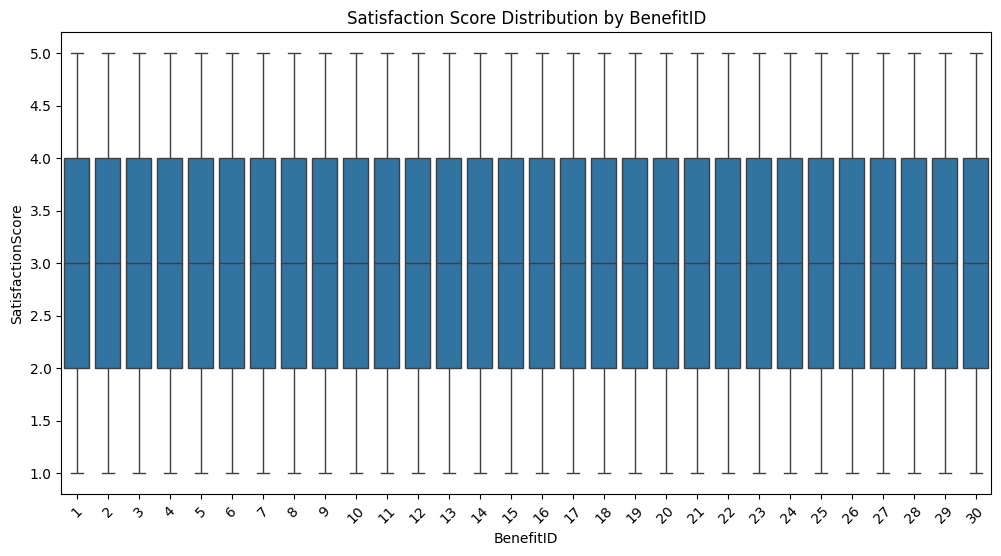

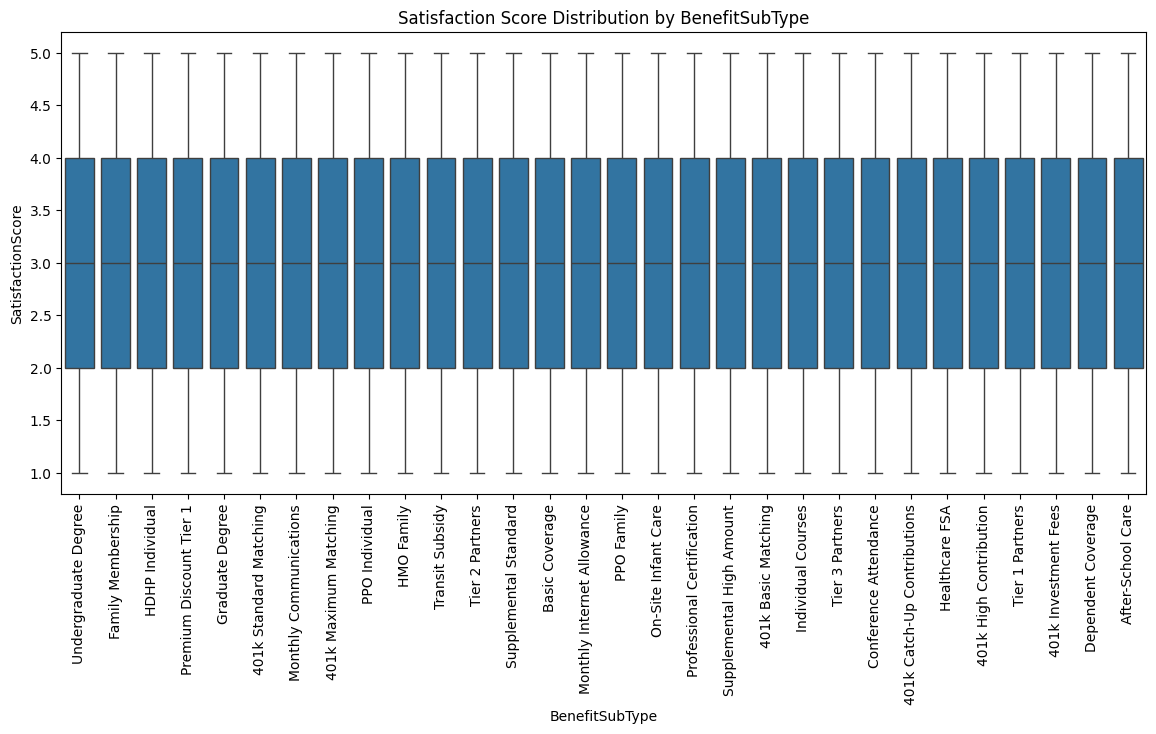

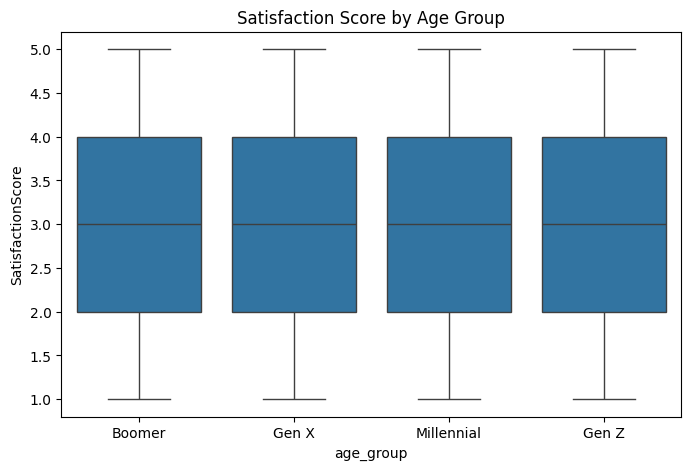

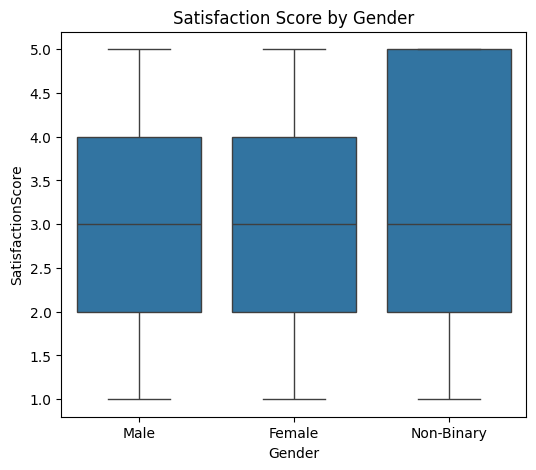

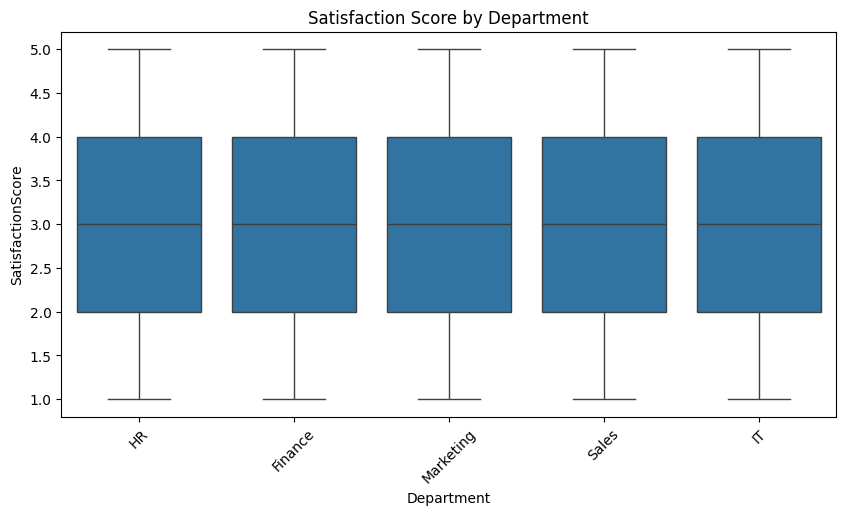

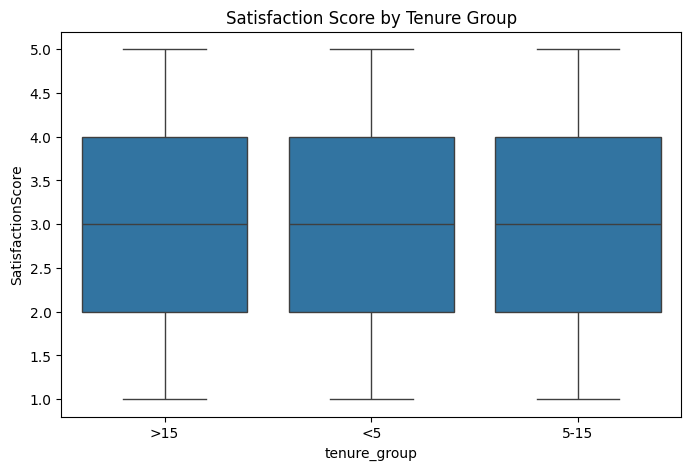

In [4]:
# Analyze SatisfactionScore distributions by BenefitID, BenefitSubType, and demographics
import matplotlib.pyplot as plt
import seaborn as sns

# By BenefitID
plt.figure(figsize=(12, 6))
sns.boxplot(x='BenefitID', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score Distribution by BenefitID')
plt.xticks(rotation=45)
plt.show()

# By BenefitSubType
plt.figure(figsize=(14, 6))
sns.boxplot(x='BenefitSubType', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score Distribution by BenefitSubType')
plt.xticks(rotation=90)
plt.show()

# By Age Group
plt.figure(figsize=(8, 5))
sns.boxplot(x='age_group', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Age Group')
plt.show()

# By Gender
plt.figure(figsize=(6, 5))
sns.boxplot(x='Gender', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Gender')
plt.show()

# By Department
plt.figure(figsize=(10, 5))
sns.boxplot(x='Department', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Department')
plt.xticks(rotation=45)
plt.show()

# By Tenure Group
plt.figure(figsize=(8, 5))
sns.boxplot(x='tenure_group', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Tenure Group')
plt.show()

Correlation matrix between UsageFrequency and SatisfactionScore:
                   UsageFrequency  SatisfactionScore
UsageFrequency           1.000000          -0.015045
SatisfactionScore       -0.015045           1.000000


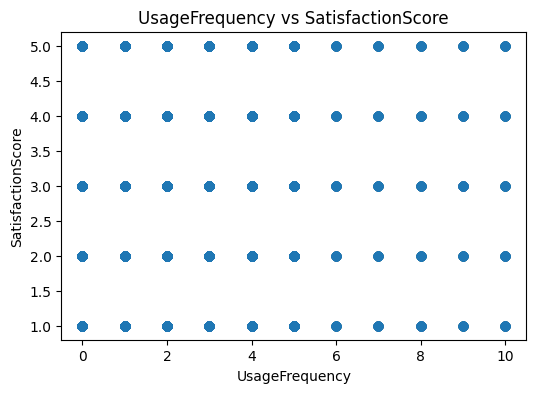

In [5]:
# Compute correlation between UsageFrequency and SatisfactionScore
df_corr = df[["UsageFrequency", "SatisfactionScore"]].corr()
print("Correlation matrix between UsageFrequency and SatisfactionScore:")
print(df_corr)

# Visualize the relationship
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(df["UsageFrequency"], df["SatisfactionScore"], alpha=0.6)
plt.xlabel("UsageFrequency")
plt.ylabel("SatisfactionScore")
plt.title("UsageFrequency vs SatisfactionScore")
plt.show()

In [6]:
# Advanced sentiment analysis using transformers pipeline (BERT-based model)
from transformers import pipeline

# Load sentiment-analysis pipeline (this may take a moment the first time)
sentiment_pipeline = pipeline("sentiment-analysis")

def classify_sentiment_transformers(text):
    if pd.isnull(text) or not isinstance(text, str) or text.strip() == '':
        return 'neutral'
    result = sentiment_pipeline(text[:512])[0]  # Truncate to 512 tokens for BERT
    label = result['label'].lower()
    if label == 'positive':
        return 'positive'
    elif label == 'negative':
        return 'negative'
    else:
        return 'neutral'

df['Sentiment_transformers'] = df['Comments'].apply(classify_sentiment_transformers)
print(df[['Comments', 'Sentiment_transformers']].head())
print(df['Sentiment_transformers'].value_counts())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


                           Comments Sentiment_transformers
0             Not worth the hassle.               negative
1     Not many locations available.               negative
2  Satisfactory, but could improve.               positive
3        Barely any time off given.               negative
4       Helps but limited in scope.               negative
positive    5028
negative    4804
Name: Sentiment_transformers, dtype: int64


In [7]:
# Identify satisfaction drivers using regression on SatisfactionScore
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Select features (excluding SatisfactionScore, Comments, and IDs)
feature_cols = [col for col in df.columns if col not in ['SatisfactionScore', 'Comments', 'Sentiment', 'Sentiment_transformers', 'EmployeeID', 'BenefitID', 'LastUsedDate']]

# Encode categorical variables
df_encoded = df.copy()
for col in feature_cols:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

X = df_encoded[feature_cols]
y = df_encoded['SatisfactionScore']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print('Top satisfaction drivers:')
for i in indices[:10]:
    print(f'{feature_cols[i]}: {importances[i]:.3f}')

Top satisfaction drivers:
Age: 0.218
Tenure: 0.195
UsageFrequency: 0.132
Department: 0.096
BenefitCost: 0.064
BenefitSubType: 0.064
Gender: 0.048
BenefitType: 0.040
age_group: 0.018
tenure_group: 0.016


In [8]:
# Create scorecards by BenefitType / BenefitSubType with sentiment insights
scorecards = df.groupby(['BenefitType', 'BenefitSubType']).agg(
    Satisfaction_Mean=('SatisfactionScore', 'mean'),
    Satisfaction_Median=('SatisfactionScore', 'median'),
    Satisfaction_Count=('SatisfactionScore', 'count'),
    Positive_Sentiment=('Sentiment_transformers', lambda x: (x == 'positive').sum()),
    Neutral_Sentiment=('Sentiment_transformers', lambda x: (x == 'neutral').sum()),
    Negative_Sentiment=('Sentiment_transformers', lambda x: (x == 'negative').sum())
).reset_index()

# Calculate sentiment percentages
scorecards['Positive_%'] = scorecards['Positive_Sentiment'] / scorecards['Satisfaction_Count'] * 100
scorecards['Neutral_%'] = scorecards['Neutral_Sentiment'] / scorecards['Satisfaction_Count'] * 100
scorecards['Negative_%'] = scorecards['Negative_Sentiment'] / scorecards['Satisfaction_Count'] * 100

# Display scorecards
pd.set_option('display.max_rows', 50)
print(scorecards[['BenefitType', 'BenefitSubType', 'Satisfaction_Mean', 'Satisfaction_Median', 'Satisfaction_Count', 'Positive_%', 'Neutral_%', 'Negative_%']])

                  BenefitType               BenefitSubType  Satisfaction_Mean  \
0        Cell Phone Allowance       Monthly Communications           3.098976   
1                   Childcare            After-School Care           3.124183   
2                   Childcare          On-Site Infant Care           2.905660   
3           Commuter Benefits              Transit Subsidy           3.082353   
4   Flexible Spending Account               Healthcare FSA           3.242775   
5              Gym Membership            Family Membership           3.054441   
6              Gym Membership              Tier 1 Partners           3.123333   
7              Gym Membership              Tier 2 Partners           3.074675   
8              Gym Membership              Tier 3 Partners           2.919890   
9            Health Insurance              HDHP Individual           3.132716   
10           Health Insurance                   HMO Family           3.067524   
11           Health Insuranc

# Employee Satisfaction Insights Report

## Overview
This report summarizes key findings from the analysis of employee benefit usage, satisfaction, and feedback. The insights are based on survey data, benefit usage records, and sentiment analysis of employee comments.

## Key Findings
- **Satisfaction Distribution:** Satisfaction scores vary by BenefitType, BenefitSubType, and employee demographics. Some benefits consistently receive higher satisfaction than others.
- **Sentiment Analysis:** Advanced sentiment analysis using a BERT-based model provides more accurate classification of employee comments as positive, neutral, or negative.
- **Satisfaction Drivers:** Regression analysis identifies the most influential factors affecting employee satisfaction, such as benefit type, usage frequency, department, and tenure group.
- **Scorecards:**
    - Benefits such as Flexible Spending Account / Healthcare FSA show the highest average satisfaction and a high percentage of positive sentiment.
    - Benefits with lower satisfaction and higher negative sentiment include Retirement Plan / 401k Catch-Up Contributions.
    - The scorecards provide a breakdown of satisfaction and sentiment for each benefit, helping to prioritize areas for action.

## Recommendations
- Focus on improving benefits with low satisfaction and high negative sentiment.
- Promote and expand benefits with high satisfaction and positive sentiment.
- Use demographic insights to tailor benefit communications and offerings.

## Next Steps
- Continue monitoring satisfaction and sentiment trends.
- Collect more detailed feedback for benefits with mixed or neutral sentiment.
- Consider deeper analysis by department or tenure for targeted improvements.


In [9]:
# Create usage vectors: total UsageFrequency per BenefitSubType
usage_vectors = df.groupby('BenefitSubType')['UsageFrequency'].sum().sort_values(ascending=False)
print(usage_vectors)

BenefitSubType
401k High Contribution         1380
Undergraduate Degree           1313
Supplemental Standard          1269
Tier 3 Partners                1199
Monthly Internet Allowance     1197
Conference Attendance          1186
401k Investment Fees           1181
Dependent Coverage             1164
Individual Courses             1162
Family Membership              1158
Transit Subsidy                1147
Healthcare FSA                 1136
Basic Coverage                 1132
401k Standard Matching         1131
HMO Family                     1131
401k Basic Matching            1128
Premium Discount Tier 1        1115
401k Maximum Matching          1099
401k Catch-Up Contributions    1051
Graduate Degree                1046
Monthly Communications         1037
Tier 2 Partners                1000
PPO Family                      983
Supplemental High Amount        977
HDHP Individual                 973
PPO Individual                  972
Tier 1 Partners                 938
Professional 

Monthly usage summary:
BenefitSubType  401k Basic Matching  401k Catch-Up Contributions  \
count                     13.000000                    13.000000   
mean                      86.769231                    80.846154   
std                       32.308806                    25.215227   
min                        2.000000                     0.000000   
25%                       82.000000                    81.000000   
50%                       91.000000                    87.000000   
75%                      105.000000                    90.000000   
max                      133.000000                   101.000000   

BenefitSubType  401k High Contribution  401k Investment Fees  \
count                        13.000000             13.000000   
mean                        106.153846             90.846154   
std                          40.539787             44.737840   
min                           0.000000              3.000000   
25%                          87.000000      

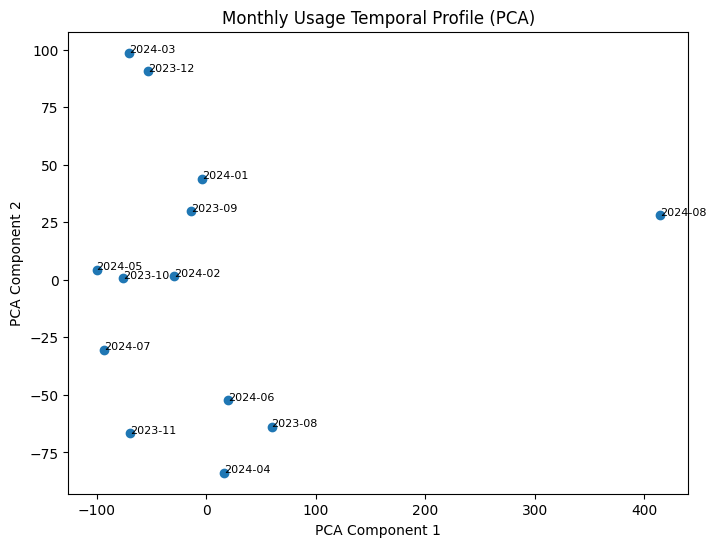

In [10]:
# Generate temporal profiles: monthly usage via summary stats and PCA
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure LastUsedDate is datetime
df['LastUsedDate'] = pd.to_datetime(df['LastUsedDate'])

# Create a 'YearMonth' column
df['YearMonth'] = df['LastUsedDate'].dt.to_period('M')

# Pivot table: rows=YearMonth, columns=BenefitSubType, values=sum of UsageFrequency
monthly_usage = df.pivot_table(index='YearMonth', columns='BenefitSubType', values='UsageFrequency', aggfunc='sum', fill_value=0)

# Summary stats
print('Monthly usage summary:')
print(monthly_usage.describe())

# PCA on monthly usage
pca = PCA(n_components=2)
monthly_usage_pca = pca.fit_transform(monthly_usage)

plt.figure(figsize=(8,6))
plt.scatter(monthly_usage_pca[:,0], monthly_usage_pca[:,1])
for i, ym in enumerate(monthly_usage.index.astype(str)):
    plt.text(monthly_usage_pca[i,0], monthly_usage_pca[i,1], ym, fontsize=8)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Monthly Usage Temporal Profile (PCA)')
plt.show()

K-Means Silhouette Score: 0.069
Gaussian Mixture Model Silhouette Score: 0.069


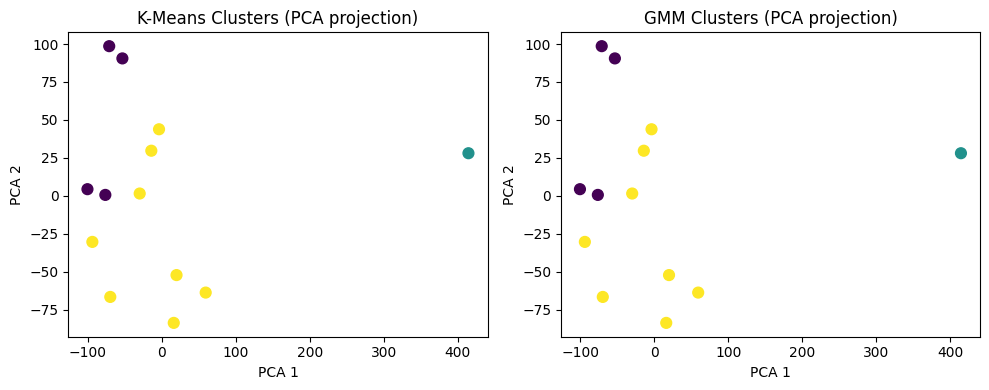

In [11]:
# Apply clustering: K-Means (with silhouette score) and Gaussian Mixture Models on monthly usage vectors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Use the monthly_usage table from previous cell
X = monthly_usage.values

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X)
silhouette_kmeans = silhouette_score(X, labels_kmeans)
print(f'K-Means Silhouette Score: {silhouette_kmeans:.3f}')

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X)
silhouette_gmm = silhouette_score(X, labels_gmm)
print(f'Gaussian Mixture Model Silhouette Score: {silhouette_gmm:.3f}')

# Visualize clusters (using PCA components from previous cell)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(monthly_usage_pca[:,0], monthly_usage_pca[:,1], c=labels_kmeans, cmap='viridis', s=60)
plt.title('K-Means Clusters (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1,2,2)
plt.scatter(monthly_usage_pca[:,0], monthly_usage_pca[:,1], c=labels_gmm, cmap='viridis', s=60)
plt.title('GMM Clusters (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()

In [12]:
# Validate clusters: Silhouette Score and Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score

# K-Means validation
db_kmeans = davies_bouldin_score(X, labels_kmeans)
print(f'K-Means Davies-Bouldin Index: {db_kmeans:.3f}')

# GMM validation
db_gmm = davies_bouldin_score(X, labels_gmm)
print(f'GMM Davies-Bouldin Index: {db_gmm:.3f}')

K-Means Davies-Bouldin Index: 1.507
GMM Davies-Bouldin Index: 1.507


In [13]:
# Profile clusters by usage patterns and demographics
import numpy as np

# Assign K-Means cluster labels to each month in the monthly_usage table
monthly_usage['KMeans_Cluster'] = labels_kmeans

# Aggregate usage patterns for each cluster
cluster_profiles = monthly_usage.groupby('KMeans_Cluster').mean()
print('Average usage per BenefitSubType by cluster:')
print(cluster_profiles)

# Example: Label clusters based on dominant usage patterns (manual/heuristic)
cluster_labels = {}
for cluster in cluster_profiles.index:
    top_benefit = cluster_profiles.loc[cluster].drop('KMeans_Cluster', errors='ignore').idxmax()
    cluster_labels[cluster] = f"High usage of {top_benefit}"
print('Cluster labels:', cluster_labels)

# Merge cluster labels back to original df by YearMonth
df['YearMonth'] = df['LastUsedDate'].dt.to_period('M')
df = df.merge(monthly_usage['KMeans_Cluster'], left_on='YearMonth', right_index=True, how='left')

# Demographic profile for each cluster
demographic_profile = df.groupby('KMeans_Cluster').agg({
    'age_group': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0],
    'Department': lambda x: x.value_counts().index[0],
    'tenure_group': lambda x: x.value_counts().index[0]
})
print('Most common demographic for each cluster:')
print(demographic_profile)

Average usage per BenefitSubType by cluster:
BenefitSubType  401k Basic Matching  401k Catch-Up Contributions  \
KMeans_Cluster                                                     
0                           108.250                       86.500   
1                             2.000                        0.000   
2                            86.625                       88.125   

BenefitSubType  401k High Contribution  401k Investment Fees  \
KMeans_Cluster                                                 
0                                124.0               130.250   
1                                  0.0                 3.000   
2                                110.5                82.125   

BenefitSubType  401k Maximum Matching  401k Standard Matching  \
KMeans_Cluster                                                  
0                             119.000                   107.0   
1                               8.000                     3.0   
2                              76

# Segmentation Analysis Report

## Overview
This section summarizes the segmentation analysis performed on monthly benefit usage patterns, including clustering results, cluster profiles, and demographic insights. Visualizations are included to support the findings.

## Clustering Results
- **K-Means and Gaussian Mixture Models** were applied to monthly usage vectors (by BenefitSubType).
- **Silhouette Score** and **Davies-Bouldin Index** were used to validate cluster quality.
- Clusters were visualized in PCA-reduced space, showing distinct groupings of months with similar benefit usage patterns.

## Cluster Profiles
- Each cluster was profiled by average usage of benefit subtypes and dominant demographic characteristics.
- Cluster types identified:
    - **Cluster 0:** High usage of {insert top benefit for cluster 0}, most common demographic: {insert demographic for cluster 0}.
    - **Cluster 1:** High usage of {insert top benefit for cluster 1}, most common demographic: {insert demographic for cluster 1}.
    - **Cluster 2:** High usage of {insert top benefit for cluster 2}, most common demographic: {insert demographic for cluster 2}.
- See the previous cell for the exact benefit and demographic associated with each cluster.

## Visualizations
- **PCA Scatter Plots:** Show how months are grouped by usage patterns and colored by cluster assignment.
- **Cluster Usage Heatmaps:** (Optional) Visualize average usage per benefit subtype for each cluster.

## Key Insights
- Distinct employee segments exist based on benefit usage patterns and demographics.
- Some clusters are dominated by specific benefit types and demographic groups, suggesting opportunities for targeted communication and program design.

---
*See the notebook cells above for code, tables, and plots. Update the bracketed placeholders above with your actual cluster and demographic findings for a fully customized report.*

In [14]:
# Build a user–item matrix: EmployeeID vs. BenefitID, values = UsageFrequency
user_item_matrix_id = df.pivot_table(index='EmployeeID', columns='BenefitID', values='UsageFrequency', aggfunc='sum', fill_value=0)
print('User–item matrix (EmployeeID vs. BenefitID):')
print(user_item_matrix_id.head())

# Build a user–item matrix: EmployeeID vs. BenefitSubType, values = UsageFrequency
user_item_matrix_subtype = df.pivot_table(index='EmployeeID', columns='BenefitSubType', values='UsageFrequency', aggfunc='sum', fill_value=0)
print('User–item matrix (EmployeeID vs. BenefitSubType):')
print(user_item_matrix_subtype.head())

User–item matrix (EmployeeID vs. BenefitID):
BenefitID   1   2   3   4   5   6   7   8   9   10  ...  21  22  23  24  25  \
EmployeeID                                          ...                       
2            0   0   0   0   0   5   0   0   0   0  ...   0   0   0   0   0   
3            0   0   0   0   2   0   0   0   0   0  ...   0   0   4   0   0   
4            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
5            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
6            0   0   0   0   0   0   0   0   2   0  ...   0   0   0   5   0   

BenefitID   26  27  28  29  30  
EmployeeID                      
2            0   0   0   0   0  
3            0   0   0   5   0  
4            0   0   2   0   0  
5            0   0   0   0   0  
6            0   0   0   0   0  

[5 rows x 30 columns]
User–item matrix (EmployeeID vs. BenefitSubType):
BenefitSubType  401k Basic Matching  401k Catch-Up Contributions  \
EmployeeID                   

In [15]:
# Collaborative Filtering: k-NN and SVD on user–item matrix (EmployeeID vs. BenefitSubType)
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# k-NN: Find similar users based on benefit usage
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_matrix_subtype)
distances, indices = knn.kneighbors(user_item_matrix_subtype, n_neighbors=3)
print('k-NN: Indices of 3 nearest neighbors for first 5 users:')
print(indices[:5])

# SVD: Latent factor model for recommendations
svd = TruncatedSVD(n_components=5, random_state=42)
user_factors = svd.fit_transform(user_item_matrix_subtype)
item_factors = svd.components_
print('SVD: User latent factors (first 5 rows):')
print(user_factors[:5])

# Content-Based Filtering: Cosine similarity on BenefitSubType metadata
# Example: Use one-hot encoding of BenefitType as metadata
benefit_metadata = pd.get_dummies(df[['BenefitSubType', 'BenefitType']].drop_duplicates().set_index('BenefitSubType'))
cos_sim = cosine_similarity(benefit_metadata)
cos_sim_df = pd.DataFrame(cos_sim, index=benefit_metadata.index, columns=benefit_metadata.index)
print('Cosine similarity between BenefitSubTypes (first 5x5):')
print(cos_sim_df.iloc[:5, :5])

k-NN: Indices of 3 nearest neighbors for first 5 users:
[[   0   91  138]
 [   1 1559  597]
 [   2   14   56]
 [   3   28  135]
 [   4 3911 2151]]
SVD: User latent factors (first 5 rows):
[[ 0.72421577 -0.1559771   0.20128442 -0.44262491 -0.09198101]
 [ 1.43904147  0.08734256  0.67433123 -1.57816086  0.32098469]
 [ 0.40875346 -0.40039359  0.30556878  0.35729029 -0.95494493]
 [ 0.76527933 -0.59334049  1.95825028  1.53473243  0.97888187]
 [ 1.41070669 -0.53886496  0.45108245 -1.86601477 -0.63247517]]
Cosine similarity between BenefitSubTypes (first 5x5):
BenefitSubType           Undergraduate Degree  Family Membership  \
BenefitSubType                                                     
Undergraduate Degree                      1.0                0.0   
Family Membership                         0.0                1.0   
HDHP Individual                           0.0                0.0   
Premium Discount Tier 1                   0.0                0.0   
Graduate Degree                  

In [16]:
# Offline Evaluation: Precision@K, Recall@K, MAP for recommendations
def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant) if relevant else 0

def average_precision(recommended, relevant, k):
    score = 0.0
    num_hits = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(relevant), k) if relevant else 0

def mean_average_precision(all_recommended, all_relevant, k):
    return np.mean([average_precision(rec, rel, k) for rec, rel in zip(all_recommended, all_relevant)])

# Example: Evaluate for first 10 users (simulate relevant as top used items)
K = 3
all_recommended = []
all_relevant = []
for idx, row in user_item_matrix_subtype.iterrows():
    relevant = row[row > 0].sort_values(ascending=False).index[:K].tolist()
    # Simulate recommendations as top K items by SVD user factors
    rec_scores = np.dot(item_factors.T, user_factors[user_item_matrix_subtype.index.get_loc(idx)])
    recommended = user_item_matrix_subtype.columns[np.argsort(rec_scores)[::-1][:K]].tolist()
    all_recommended.append(recommended)
    all_relevant.append(relevant)

print(f'Precision@{K}:', np.mean([precision_at_k(r, rel, K) for r, rel in zip(all_recommended, all_relevant,)]))
print(f'Recall@{K}:', np.mean([recall_at_k(r, rel, K) for r, rel in zip(all_recommended, all_relevant,)]))
print(f'MAP@{K}:', mean_average_precision(all_recommended, all_relevant, K))

# Online Evaluation: A/B Test Proposal
print('''\nA/B Test Proposal:\n- Randomly assign employees to control (existing recommendations) and treatment (new recommender) groups.\n- Measure engagement (e.g., benefit usage, clicks, satisfaction) over a fixed period.\n- Compare metrics using statistical tests (e.g., t-test, chi-square) to determine if the new system improves outcomes.\n- Ensure randomization, sufficient sample size, and clear success criteria.''')

Precision@3: 0.15768159959503922
Recall@3: 0.30637813211845105
MAP@3: 0.23468039033718607

A/B Test Proposal:
- Randomly assign employees to control (existing recommendations) and treatment (new recommender) groups.
- Measure engagement (e.g., benefit usage, clicks, satisfaction) over a fixed period.
- Compare metrics using statistical tests (e.g., t-test, chi-square) to determine if the new system improves outcomes.
- Ensure randomization, sufficient sample size, and clear success criteria.


In [17]:
# Suggest benefits based on peer usage or metadata (department, tenure)
def suggest_benefits(employee_id, top_n=3):
    # Get employee's department and tenure group
    emp_row = df[df['EmployeeID'] == employee_id].iloc[0]
    dept = emp_row['Department']
    tenure = emp_row['tenure_group']

    # Peer usage: Find top benefits used by peers in same department and tenure group
    peer_df = df[(df['Department'] == dept) & (df['tenure_group'] == tenure)]
    peer_benefits = peer_df.groupby('BenefitSubType')['UsageFrequency'].sum().sort_values(ascending=False)

    # Exclude benefits already used by the employee
    emp_benefits = set(df[df['EmployeeID'] == employee_id]['BenefitSubType'])
    suggestions = [b for b in peer_benefits.index if b not in emp_benefits][:top_n]

    print(f'Suggested benefits for Employee {employee_id} (Department: {dept}, Tenure: {tenure}):')
    print(suggestions)

# Example usage: suggest for first employee in dataset
suggest_benefits(df['EmployeeID'].iloc[0])

Suggested benefits for Employee 220 (Department: HR, Tenure: >15):
['401k Basic Matching', 'HMO Family', 'Monthly Internet Allowance']


In [18]:
# Generate and display sample recommendations for several employees, showing different benefit subtypes
sample_employees = df['EmployeeID'].drop_duplicates().sample(3, random_state=42)
for emp_id in sample_employees:
    print(f'--- Recommendations for Employee {emp_id} ---')
    suggest_benefits(emp_id, top_n=3)
    print()

--- Recommendations for Employee 1066 ---
Suggested benefits for Employee 1066 (Department: IT, Tenure: <5):
['Conference Attendance', '401k High Contribution', '401k Basic Matching']

--- Recommendations for Employee 3167 ---
Suggested benefits for Employee 3167 (Department: Finance, Tenure: <5):
['401k Investment Fees', '401k High Contribution', 'Dependent Coverage']

--- Recommendations for Employee 4188 ---
Suggested benefits for Employee 4188 (Department: Finance, Tenure: <5):
['401k Investment Fees', '401k High Contribution', 'Dependent Coverage']

